In [1]:
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
# inline plotting instead of popping out
%matplotlib inline

import os, sys
from lib import *

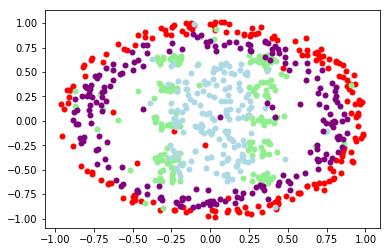

In [2]:
#Training data

file = open('./data/lab8/train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

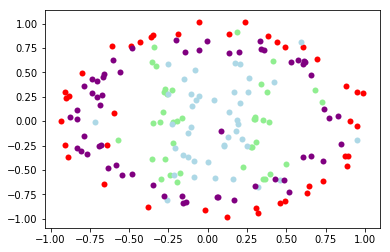

In [4]:
#Testing data

file = open('./data/lab8/test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_test = np.ndarray((0, 2))
y_test = np.ndarray((0,))
y_test_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X_test = np.vstack((X_test, np.array(row[0:2])))
    y_test = np.append(y_test, y_test_mapping[row[2]])
X_test = X_test.astype(np.float)
y_test = y_test.astype(np.float)
file.close()

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_test[y_test == 2, 0], X_test[y_test == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_test[y_test == 3, 0], X_test[y_test == 3, 1], label='Sue', c='purple', linewidths=0)

## KNN

In [5]:
#KNN
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    x_train, x_otest = X[train_idx], X[test_idx]
    y_train, y_otest = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [1, 3, 5, 10, 15]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(x_train, y_train):
            x_itrain, x_val = x_train[itrain_idx], x_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(x_itrain, y_itrain)
            
            y_pred = pipe.predict(x_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X, y)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.77 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.79 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.79 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.79 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.79 (n_neighbors=3 selected by inner 10-fold CV)

Test accuracy: 0.79 (5x10 nested CV)


## Voting

In [6]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(random_state=0, solver='saga', multi_class='ovr')]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X, y=y, cv=10, scoring=make_scorer(accuracy_score))
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.274 (+/- 0.039)
DecisionTree: 0.506 (+/- 0.034)
KNN: 0.821 (+/- 0.046)


In [7]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=make_scorer(accuracy_score))
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.824 (+/- 0.046)
(0, 2, 1): 0.759 (+/- 0.038)
(1, 0, 2): 0.820 (+/- 0.046)
(1, 2, 0): 0.506 (+/- 0.034)
(2, 0, 1): 0.813 (+/- 0.060)
(2, 1, 0): 0.493 (+/- 0.040)

Best (0, 1, 2): 0.824


In [8]:
best_vt.fit(X, y)
y_pred = best_vt.predict(X_test)
print('Test accuracy: %.4f ' % accuracy_score(y_test, y_pred))

Test accuracy: 0.7784 


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


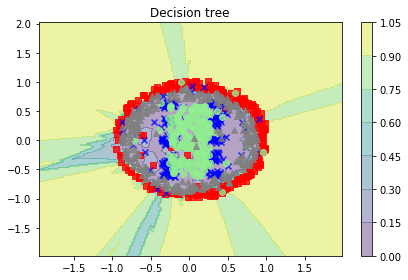

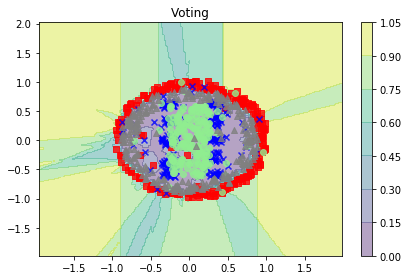

In [9]:
X_combined = np.vstack((X, X_test))
y_combined = np.hstack((y, y_test))

pipe3.fit(X, y)

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3, soft=True,
                      test_idx=range(len(y),  len(y) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt, soft=True,
                      test_idx=range(len(y),  len(y) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.show()

## Bagging

In [10]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# single DecisionTree
tree = tree.fit(X, y)
y_train_pred = tree.predict(X)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# Bagging
bag = bag.fit(X, y)
y_train_pred = bag.predict(X)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.800
[Bagging] auc-train = 0.991, auc-test = 0.811


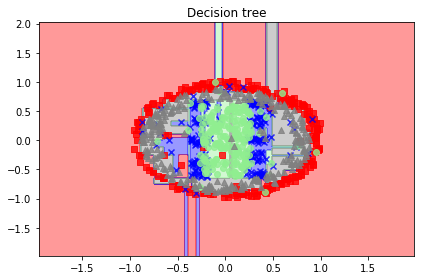

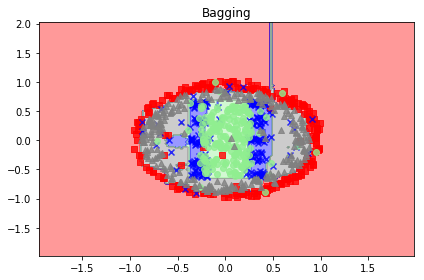

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


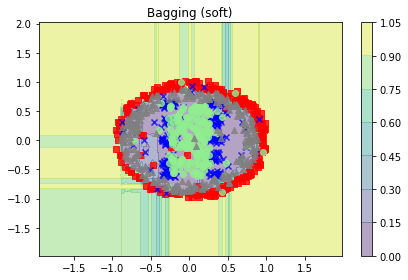

In [11]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, soft=True,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('Bagging (soft)')
plt.tight_layout()
plt.show()

## Boosting

-------- Decision Stump (Max_depth = 1) --------
[DecisionTree] accuracy-train = 0.370, accuracy-test = 0.292
[AdaBoost] accuracy-train = 0.615, accuracy-test = 0.530
-------- Best Max Depth : 12 --------
[DecisionTree] accuracy-train = 0.973, accuracy-test = 0.768
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.827


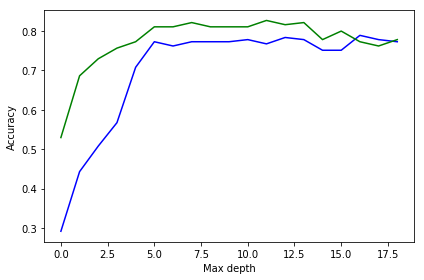

In [12]:
from sklearn.ensemble import AdaBoostClassifier

##Using linear search to find best base learner

best_tree, best_ada = None, None
tree_test, ada_test = [], []
for depth in range(1, 20):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    # single decision tree
    tree = tree.fit(X, y)
    y_test_pred = tree.predict(X_test)
    tree_test.append( accuracy_score(y_test, y_test_pred) )
    
    # adaboost
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
    ada = ada.fit(X, y)
    y_test_pred = ada.predict(X_test)
    ada_test.append( accuracy_score(y_test, y_test_pred) )

    if len(ada_test)==1:
        best_tree, best_ada = tree, ada
        print('-------- Decision Stump (Max_depth = 1) --------')
        y_train_pred = tree.predict(X)
        tree_train = accuracy_score(y, y_train_pred)
        print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test[0]))
        y_train_pred = ada.predict(X)
        tree_train = accuracy_score(y, y_train_pred)
        print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, ada_test[0]))
    elif ada_test[-1] > max(ada_test[:-1]):
        best_tree, best_ada = tree, ada
        
best_depth =  ada_test.index(max(ada_test)) + 1
print('-------- Best Max Depth : %d --------' % best_depth)
y_train_pred = best_tree.predict(X)
tree_train = accuracy_score(y, y_train_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test[best_depth-1]))
y_train_pred = best_ada.predict(X)
tree_train = accuracy_score(y, y_train_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, ada_test[best_depth-1]))


plt.plot(tree_test, color='blue')
plt.plot(ada_test, color='green')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [18]:
##Using GridSearchCV to find best base learner

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    
    tree =  DecisionTreeClassifier(criterion='entropy') 
    # hyperparameter tuning by grid search CV
    param_grid = {'max_depth':[1, 3, 5, 10, 15, 20]}
    gs = GridSearchCV(estimator=tree, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_tree = gs.best_estimator_
    ada = AdaBoostClassifier(base_estimator=best_tree, n_estimators=500)
    ada.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_val, y_val))
    print('Validation accuracy: %.3f (max_depth=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['max_depth']))

print('\nValidation accuracy: %.3f (5x10 nested CV)' % np.mean(outer_scores))


[Outer fold 1/5]
Validation accuracy: 0.912 (max_depth=10 selected by inner 10-fold CV)
[Outer fold 2/5]
Validation accuracy: 0.905 (max_depth=10 selected by inner 10-fold CV)
[Outer fold 3/5]
Validation accuracy: 0.899 (max_depth=20 selected by inner 10-fold CV)
[Outer fold 4/5]
Validation accuracy: 0.912 (max_depth=10 selected by inner 10-fold CV)
[Outer fold 5/5]
Validation accuracy: 0.905 (max_depth=10 selected by inner 10-fold CV)

Validation accuracy: 0.907 (5x10 nested CV)


[DecisionTree] accuracy-train = 0.949, accuracy-test = 0.773
[AdaBoost] accuracy-train = 0.805, accuracy-test = 0.789


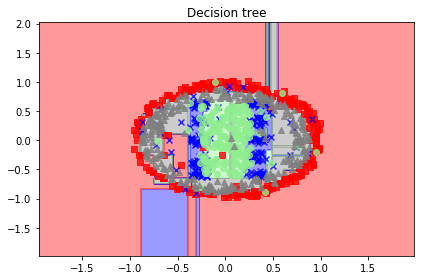

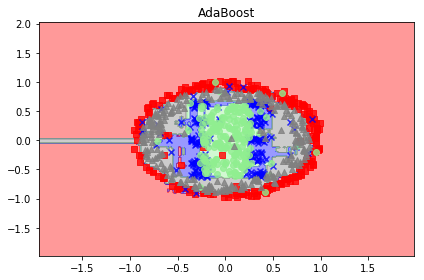

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


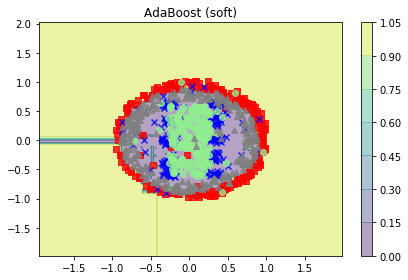

In [19]:
## testing max_depth=10 for adaBoost

best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
best_tree = best_tree.fit(X, y)
y_train_pred = best_tree.predict(X)
y_test_pred = best_tree.predict(X_test)
tree_train = accuracy_score(y, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))


best_ada = AdaBoostClassifier(base_estimator=best_tree, n_estimators=500)
best_ada = best_ada.fit(X, y)
y_train_pred = best_ada.predict(X)
y_test_pred = best_ada.predict(X_test)
ada_train = accuracy_score(y, y_train_pred)
ada_train = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (ada_train, ada_test))


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_tree,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_ada,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_ada, soft=True,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('AdaBoost (soft)')
plt.tight_layout()
plt.show()

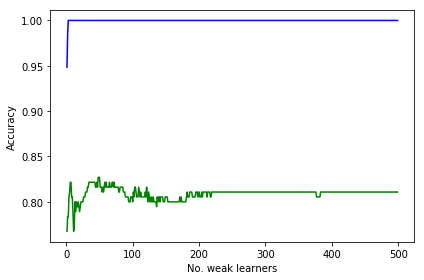

In [15]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=best_tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X, y)
    y_train_pred = ada.predict(X)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

[AdaBoost16] accuracy-train = 1.000, accuracy-test = 0.789


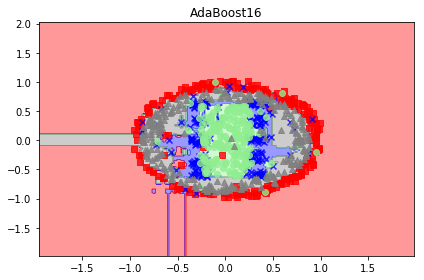

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


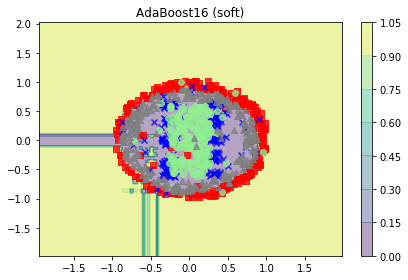

In [16]:
ada16 = AdaBoostClassifier(base_estimator=best_tree, n_estimators=16)
ada16.fit(X, y)
y_train_pred = ada16.predict(X)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost16] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('AdaBoost16')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16, soft=True,
                      test_idx=range(len(y), 
                                     len(y) + len(y_test)))
plt.title('AdaBoost16 (soft)')
plt.tight_layout()
plt.show()

## Final Summary

The best model I've got is Boosting with 500 estimators using Decision tree with max_depth=12 as base learner, which got 1.0 accuracy in training data and 0.827 in testing data 